In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/privacy_permutation/')

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

#from torchsummary import summary
!pip install torchinfo -q
from torchinfo import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import scipy.signal as signal

import utils

# %matplotlib widget
%matplotlib notebook
%matplotlib inline

/tmp/ipykernel_29953/1357141929.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
utils.setup_seed(1312)

In [3]:
img_size = 33

test = utils.Permutar(img_size, 1)
test.key.reshape(33,33)

array([[ 608,  275,  171, ...,  160,  829,  751],
       [ 543,  230,  739, ...,  541,  695,  156],
       [ 712,  539,   68, ...,  786,   64, 1007],
       ...,
       [ 902,  175,  855, ...,  808,  682,  526],
       [ 581, 1078,  409, ...,  388,  278,  237],
       [  90,   30,  375, ...,  791,  176,   81]])

dataloader

In [4]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform=transforms.Compose([
    T.Resize((33,33)),
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))
    ])

trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

fake_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False, drop_last=True)
dataset = list(fake_loader)

images, labels = torch.tensor([]), torch.tensor([])

for batch in dataset:
  test = utils.Permutar(33,1)
  image_batch = test.desordenar(batch[0])

  images = torch.cat((images, image_batch)) if images.numel() != 0 else image_batch
  labels = torch.cat((labels, batch[1])) if labels.numel() != 0 else batch[1]
trainset_disorderly = torch.utils.data.TensorDataset(images,labels)

images, labels = torch.tensor([]), torch.tensor([])

for batch in testset:
  test = utils.Permutar(33,1)
  image_batch = test.desordenar(batch[0])

  images = torch.cat((images, image_batch)) if images.numel() != 0 else image_batch
  labels = torch.cat((labels, batch[1])) if labels.numel() != 0 else batch[1]
testset_disorderly = torch.utils.data.TensorDataset(images,labels)


train_loader = torch.utils.data.DataLoader(trainset_disorderly, batch_size=64, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, drop_last=True)

IndexError: too many indices for tensor of dimension 3

In [ ]:
list(testset).shape

[(tensor([[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           ...,
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]]),
  9),
 (tensor([[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           ...,
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
           [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]]),
  2),
 (tensor([[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
 

: 

: 

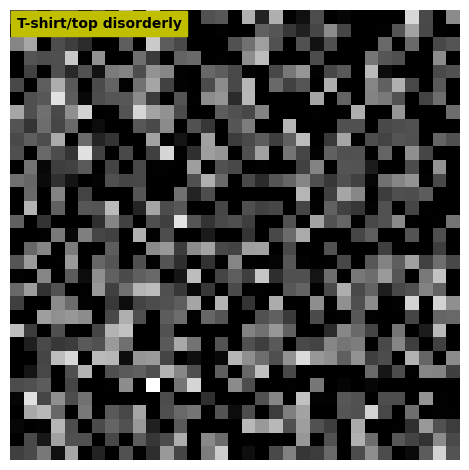

In [9]:
a = next(iter(train_loader))
X,y = [a[0][0], a[1][0]]


pic = X.data.cpu().numpy().transpose((1,2,0))
pic = pic-np.min(pic) # undo normalization
pic = pic/np.max(pic)

label = testset.classes[y]

plt.imshow(pic, cmap='gray')
plt.text(0,0,f'{label} disorderly',ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')

plt.axis('off')

plt.tight_layout()
plt.show()

### network

In [10]:
from permuted_newtork import PermutedNetwork_2, PermutedNetwork

model = PermutedNetwork().to(device)

In [ ]:
model.load_state_dict(torch.load('model_weights.pth'), strict=False)

In [13]:
summary(model, (1, 1, 33, 33))

Layer (type:depth-idx)                   Output Shape              Param #
PermutedNetwork                          [1, 10]                   --
├─Conv2d: 1-1                            [1, 18, 31, 31]           180
├─DeformConv2d: 1-2                      [1, 16, 31, 31]           160
├─Conv2d: 1-3                            [1, 18, 29, 29]           2,610
├─DeformConv2d: 1-4                      [1, 32, 29, 29]           4,640
├─Conv2d: 1-5                            [1, 50, 25, 25]           40,050
├─DeformConv2d: 1-6                      [1, 16, 25, 25]           12,816
├─Conv2d: 1-7                            [1, 98, 19, 19]           76,930
├─DeformConv2d: 1-8                      [1, 16, 19, 19]           12,560
├─Conv2d: 1-9                            [1, 50, 15, 15]           20,050
├─DeformConv2d: 1-10                     [1, 8, 15, 15]            3,208
├─Conv2d: 1-11                           [1, 18, 13, 13]           1,314
├─DeformConv2d: 1-12                     [1, 4, 13,

In [ ]:
#model.conv1.requires_grad_(False)
#model.conv2.requires_grad_(False)
#model.conv3.requires_grad_(False)
#model.conv4.requires_grad_(False)
#model.conv5.requires_grad_(False)
#model.conv6.requires_grad_(False)

In [14]:
# Define the loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Train the network
epochs = 5

trainLoss = torch.zeros(epochs)
testLoss  = torch.zeros(epochs)
trainAcc  = torch.zeros(epochs)
testAcc   = torch.zeros(epochs)

for e in range(epochs):
    model.train()

    batchLoss = []
    batchAcc  = []

    for images, labels in train_loader:
        
        optimizer.zero_grad()

        images = images.to(device)
        labels = labels.to(device)

        output = model(images)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        batchLoss.append(loss.item())
        batchAcc.append( (output.argmax(dim=1) == labels).type(torch.float).mean() )

    trainLoss[e] = torch.tensor(batchLoss).mean()
    trainAcc[e]  = torch.tensor(batchAcc).mean()

    model.eval()
    batchLoss = []
    batchAcc  = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device) #test.desordenar(images).to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            batchLoss.append(loss.item())
            batchAcc.append((output.argmax(dim=1) == labels).type(torch.float).mean())

    testLoss[e] = torch.tensor(batchLoss).mean()
    testAcc[e]  = torch.tensor(batchAcc).mean()

    print(f"Epoch {e+1}/{epochs} Test Loss: {testLoss[e]:.3f} Test Acc: {testAcc[e]:.3f}, Train Loss: {trainLoss[e]:.3f} Train Acc: {trainAcc[e]:.3f}")



KeyboardInterrupt: 

: 

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (croos entropy)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('network on mnist',fontweight='bold',fontsize=14)
plt.show()

In [ ]:
X,y = next(iter(test_loader))

X = test.desordenar(X).to(device)
y = y.to(device)


predictions = torch.argmax( model(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)

  ax.imshow(pic, cmap='gray')


  # label and true class
  #print(i)
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'

  # set the title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(15,32,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# test
model.eval()
batchLoss = []
batchAcc  = []

with torch.no_grad():
    for images, labels in test_loader:
        images = test.desordenar(images).to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)
        batchLoss.append(loss.item())
        batchAcc.append((output.argmax(dim=1) == labels).type(torch.float).mean())

testLoss = torch.tensor(batchLoss).mean()
testAcc  = torch.tensor(batchAcc).mean()

print(testLoss,testAcc)

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')